# Analyzing US Census Data for HigherME
**Nava Roohi ,Cole Bailey, Filipp Krasovsky**

In [1]:
import pandas as pd 

In [52]:
df = pd.read_csv("new_df.csv")
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE
0,2020,2019,202003,831794,2019000366232,13.39,2020008317943,6,190406,1,...,63,0,0,0,0,2,20,5400,6880,13162
1,2020,2016,202003,5766905,2016001119934,28.84,2020057669053,48,540048,1,...,65,0,0,0,0,1,10,9130,9070,47138
2,2020,2018,202003,2702049,2018000367760,15.45,2020027020493,22,240022,1,...,63,0,0,0,0,1,10,2752,8561,36079
3,2020,2017,202003,2509076,2017001008029,38.11,2020025090763,20,60220,1,...,71,0,0,0,0,3,30,0,0,0
4,2020,2019,202003,886494,2019000936167,18.54,2020008864943,6,670906,1,...,63,0,0,0,0,3,30,0,0,0


## Data Cleaning

#### Step 1. State Extraction from FIP Numbers

In [56]:
fips = {
    1:"Alabama",2:"Alaska",4:"Arizona",5:"Arkansas",6:"California",8:"Colorado",9:"Connecticut"
    ,10:"Delaware",11:"District of Columbia",12:"Florida",13:"Georgia",15:"Hawaii",16:"Idaho"
    ,17:"Illinois",18:"Indiana",19:"Iowa",20:"Kansas",21:"Kentucky",22:"Louisiana",23:"Maine"
    ,24:"Maryland",25:"Massachusetts",26:"Michigan",27:"Minnesota",28:"Mississippi",29:"Missouri"
    ,30:"Montana",31:"Nebraska",32:"Nevada",33:"New Hampshire",34:"New Jersey",35:"New Mexico"
    ,36:"New York",37:"North Carolina",38:"North Dakota",39:"Ohio",40:"Oklahoma",41:"Oregon"
    ,42:"Pennsylvania",44:"Rhode Island",45:"South Carolina",46:"South Dakota",47:"Tennessee"
    ,48:"Texas",49:"Utah",50:"Vermont",51:"Virginia",53:"Washington",54:"West Virginia"
    ,55:"Wisconsin",56:"Wyoming",61:"Maine-New Hampshire-Vermont",62:"Massachusetts-Rhode Island"
    ,63:"Minnesota-Iowa-Missouri-Kansas-Nebraska-S.Dakota-N.Dakota",64:"Maryland-Delaware"
    ,65:"Montana-Idaho-Wyoming",66:"Utah-Nevada",67:"Arizona-New Mexico",68:"Alaska-Hawaii"
    ,72:"Puerto Rico",97:"Military/Mil. Reservation",99:"State not identified"
}

In [58]:
#map to a new variable called "State"
df['State'] = df['STATEFIP'].apply(lambda x:fips[x])
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE,State
0,2020,2019,202003,831794,2019000366232,13.39,2020008317943,6,190406,1,...,0,0,0,0,2,20,5400,6880,13162,California
1,2020,2016,202003,5766905,2016001119934,28.84,2020057669053,48,540048,1,...,0,0,0,0,1,10,9130,9070,47138,Texas
2,2020,2018,202003,2702049,2018000367760,15.45,2020027020493,22,240022,1,...,0,0,0,0,1,10,2752,8561,36079,Louisiana
3,2020,2017,202003,2509076,2017001008029,38.11,2020025090763,20,60220,1,...,0,0,0,0,3,30,0,0,0,Kansas
4,2020,2019,202003,886494,2019000936167,18.54,2020008864943,6,670906,1,...,0,0,0,0,3,30,0,0,0,California


### Step 2. Breakdown by Race, Initial EDA 

In [61]:
race_map ={
    1: "White"
    ,2: "Black/African American"
    ,3: "American Indian or Alaska Native"
    ,4: "Chinese"
    ,5: "Japanese"
    ,6: "Other Asian or Pacific Islander"
    ,7: "Other race, nec"
    ,8: "Two major races"
    ,9: "Three or more major races"
}
df['RACE'].apply(lambda x: race_map[x]).value_counts()

White                               150865
Black/African American               19509
Other race, nec                       7895
Two major races                       7688
Other Asian or Pacific Islander       7619
Chinese                               2739
American Indian or Alaska Native      2316
Three or more major races              883
Japanese                               486
Name: RACE, dtype: int64

Based on the definition, however, we are primarily interested in exploring career differences between non-white/asian individuals and their counterparts based on documentation that can be accessed <a href="https://github.com/kayfilipp/HigherME/blob/main/README.md">here </a>. To this end, we can re-map the race for each row to exclude indices 1, 4, and 5. We do not exclude pacific islanders as of now, but are open to doing so if requirements change.

In [66]:
non_target = [1,3,5]
def under_rep_id(race):
    if race not in non_target:
        return 1
    return 0

df['under_represented'] = df['RACE'].map(under_rep_id)
df[['RACE','under_represented']].sample(10)

,RACE,under_represented
43535,1,0
91412,7,1
155852,1,0
97515,1,0
132372,1,0
55149,1,0
76424,1,0
69873,2,1
34889,2,1
195544,1,0


<AxesSubplot:title={'center':'Under represented presence in dataset'}>

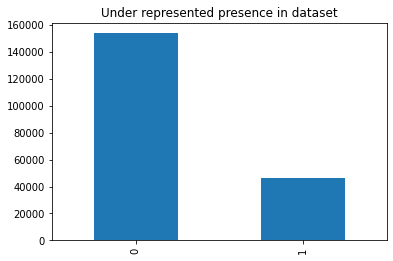

In [69]:
df['under_represented'].value_counts().plot(kind='bar',title='Under represented presence in dataset')

#### Since we're not doing low level analysis that explores the differences between Black and Hispanic applicants, we can drop the nuance on hispanic data for now.

In [71]:
df = df.drop(['HISPAN','HISPAND'],axis=1)

### Step 3. Breakdown by Birthplace, EDA

#### Furthermore, we can divide the birthplace feature (BPL) into a more low-resolution field - foreign born and domestic born individuals (ie those who are born in the continental US):

In [79]:
def is_domestic(bpl):
    if bpl < 100:
        return 1
    return 0

df['domestic_born'] = df['BPL'].map(is_domestic)
df[['BPL','domestic_born']].head()

,BPL,domestic_born
0,200,0
1,48,1
2,405,0
3,29,1
4,6,1


Putting all this together, we can conclude that individuals that are born abroad and move to the US tend to have more parity between represented and underrepresented groups while, as intiuition dictates, individuals born in the US tend to not be underrepresented. 

<AxesSubplot:title={'center':'Distribution of Underrepresented indivudlas by birthplace'}, xlabel='domestic_born'>

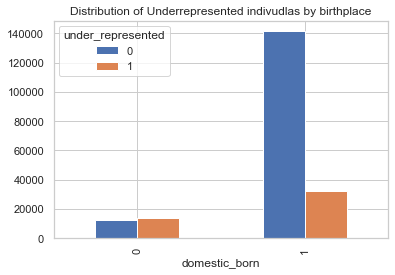

In [109]:
pd.crosstab(
    df['domestic_born'],
    df['under_represented']
).plot.bar(
    title='Distribution of Underrepresented persons by birthplace'
)

### Step 4. Educational Attainment, EDA

**Context:** The ``EDUC`` field contains values from 0-11 representing levels of educational attainment in increasing order - that is, a 0 is lower than a 1, etc. The `EDUCD` field extrapolates on the low-level details in a similar fashion. Our primary motivation is to simplify these values broadly into the following categories:

<ul>
    <li>None/Below Secondary (High School)</li>
    <li>Secondary (High School)</li>
    <li>Bachelor's</li>
    <li>Master's</li>
    <li>PhD/Other</li>
</ul>

In [111]:
df['EDUC'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)

In [114]:
df['EDUCD'].sort_values().unique()

array([  1,   2,  11,  12,  14,  15,  16,  17,  22,  23,  25,  26,  30,
        40,  50,  61,  63,  64,  65,  71,  81, 101, 114, 115, 116],
      dtype=int64)

In [118]:
def highest_edu(educd):
    if educd in [81,82,83]:
        return 'Associate'
    if educd == 101:
        return 'Bachelor'
    if educd in [114,115]:
        return 'Master'
    if educd in [116]:
        return 'PhD'
    if educd < 62 or educd==999:
        return 'None/Below HS'
    if educd < 114:
        return 'High School'
    
df['EDU_verbose'] = df['EDUCD'].map(highest_edu)
df[['EDU_verbose','EDUCD']].tail()

,EDU_verbose,EDUCD
199995,Associate,81
199996,Bachelor,101
199997,Master,114
199998,High School,63
199999,Bachelor,101


In [125]:
pd.crosstab(
    df['under_represented'],
    df['EDU_verbose'],
    normalize='index'
)

EDU_verbose,Associate,Bachelor,High School,Master,None/Below HS,PhD
under_represented,,,,,,
0,0.069058,0.160711,0.407778,0.08810,0.262978,0.011375
1,0.052425,0.124490,0.369132,0.06954,0.372844,0.011568


<AxesSubplot:title={'center':'Distribution of Underrepresented indivudlas by birthplace'}, xlabel='under_represented'>

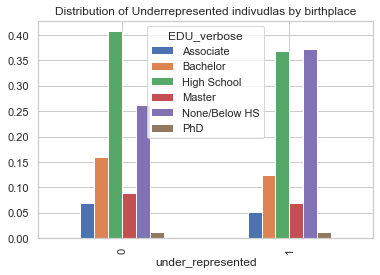

In [126]:
pd.crosstab(
    df['under_represented'],
    df['EDU_verbose'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented indivudlas by birthplace'
)